In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Input, Model

In [3]:
from data_import_preprocessing import import_data_preprocessing

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    gpu_num = 1
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
        #tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[gpu_num],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    except RuntimeError as e:
        print(e)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [6]:
train_data_name = 'data/nb_data_changed_HT_1-1.csv'
test_data_name = 'data/nb_data_changed_HT_1-2.csv'
preprocessing = import_data_preprocessing(train_data_file_name = train_data_name,
                                          test_data_file_name= test_data_name,
                                          
                                         )
print('train_data : ', preprocessing.train_data_file_sample_column)
print('train_data : ', preprocessing.test_data_file_sample_column)

train_data :  ['target', 'target_20bp', 'indel_percent', 'indel_rate']
train_data :  ['target', 'target_20bp', 'indel_percent', 'indel_rate']


In [7]:
data = preprocessing(sgRNA_column='target',
                    indel_column='indel_percent',
                    split_data=0.1
                    )

In [8]:
print(data.keys())
print(data['train'].keys())

dict_keys(['train', 'val', 'total', 'test'])
dict_keys(['seq', 'indel_rate', 'indel_class', 'read_cnt', 'info'])


In [9]:
X_train = data['train']['seq']
class_train = data['train']['indel_class']
rate_train = data['train']['indel_rate']

X_val = data['val']['seq']
class_val = data['val']['indel_class']
rate_val = data['val']['indel_rate']

X_test = data['test']['seq']
class_test = data['test']['indel_class']
rate_test = data['test']['indel_rate']

input_shape = X_train.shape[1:]

In [10]:
X_val.shape

(1500, 34, 4)

In [11]:
batch_size = 128

en_lr = 0.001
en_epochs = 500

dnn_lr = 0.001
dnn_epochs = 400


dropout_RNN = 0.5
dropout_RNN_out = 0.5
dropout_DNN = 0.5
dropout2_DNN = 0.5


DNN_1 = 100
DNN_2 = 100
DNN_3 = 100

DNN_num_mis_1 = 100
DNN_num_mis_2 = 100
DNN_num_mis_3 = 5

DNN_class_1 = 100
DNN_class_2 = 100
DNN_class_3 = 11

DNN_rate_1 = 100
DNN_rate_2 = 100
DNN_rate_3 = 1

verbose = 1

In [12]:
CNNLSTM_input = Input(shape=input_shape)
#CNNLSTM_input_reshape = Reshape((23,8))(CNNLSTM_input)

kernal0 = 16
dropout0 = 0.5
CNN0_1 = Conv1D(kernal0, [1], activation='relu', padding='same', kernel_initializer='he_normal')(CNNLSTM_input)
CNN0_1 = Dropout(0.3)(CNN0_1)

CNN0_2 = Conv1D(kernal0, [2], activation='relu', padding='same', kernel_initializer='he_normal')(CNNLSTM_input)
CNN0_2 = Dropout(0.3)(CNN0_2)

CNN0_3 = Conv1D(kernal0, [3], activation='relu', padding='same', kernel_initializer='he_normal')(CNNLSTM_input)
CNN0_3 = Dropout(0.3)(CNN0_3)

CNN0_4 = Conv1D(kernal0, [4], activation='relu', padding='same', kernel_initializer='he_normal')(CNNLSTM_input)
CNN0_4 = Dropout(0.3)(CNN0_4)

CNN0_5 = Conv1D(kernal0, [5], activation='relu', padding='same', kernel_initializer='he_normal')(CNNLSTM_input)
CNN0_5 = Dropout(0.3)(CNN0_5)

concatenate0 = concatenate([CNN0_1, CNN0_2, CNN0_3, CNN0_4, CNN0_5])

#squeezed = Lambda(lambda x: keras.backend.squeeze(x,axis=2))(concatenate0)

LSTM0 = LSTM(64, return_sequences=True)(concatenate0)
LSTM0 = Dropout(dropout0)(LSTM0)

concatenate1 = concatenate([LSTM0, CNNLSTM_input])


kernal1 = 32
dropout1 = 0.5
CNN1_1 = Conv1D(kernal1, [1], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate1)
CNN1_1 = Dropout(dropout1)(CNN1_1)

CNN1_2 = Conv1D(kernal1, [2], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate1)
CNN1_2 = Dropout(dropout1)(CNN1_2)

CNN1_3 = Conv1D(kernal1, [3], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate1)
CNN1_3 = Dropout(dropout1)(CNN1_3)

CNN1_4 = Conv1D(kernal1, [4], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate1)
CNN1_4 = Dropout(dropout1)(CNN1_4)

CNN1_5 = Conv1D(kernal1, [5], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate1)
CNN1_5 = Dropout(dropout1)(CNN1_5)

CNN1_concatenate = concatenate([CNN1_1, CNN1_2, CNN1_3, CNN1_4, CNN1_5])

LSTM1 = LSTM(128, return_sequences=True)(CNN1_concatenate)
LSTM1 = Dropout(dropout1)(LSTM1)


#concatenate2 = concatenate([CNNLSTM_input_reshape,LSTM1])
concatenate2 = concatenate([LSTM1, LSTM0])
kernal2 = 64
dropout2 = 0.5
CNN2_1 = Conv1D(kernal2, [1], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate2)
#CNN2_1 = MaxPool1D()(CNN2_1)
CNN2_1 = Dropout(dropout2)(CNN2_1)

CNN2_2 = Conv1D(kernal2, [2], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate2)
#CNN2_2 = MaxPool1D()(CNN2_2)
CNN2_2 = Dropout(dropout2)(CNN2_2)

CNN2_3 = Conv1D(kernal2, [3], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate2)
#CNN2_3 = MaxPool1D()(CNN2_3)
CNN2_3 = Dropout(dropout2)(CNN2_3)

CNN2_4 = Conv1D(kernal2, [4], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate2)
#CNN2_4 = MaxPool1D()(CNN2_4)
CNN2_4 = Dropout(dropout2)(CNN2_4)

CNN2_5 = Conv1D(kernal2, [5], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate2)
#CNN2_5 = MaxPool1D()(CNN2_5)
CNN2_5 = Dropout(dropout2)(CNN2_5)

CNN2_concatenate = concatenate([CNN2_1, CNN2_2, CNN2_3, CNN2_4, CNN2_5])

LSTM2 = LSTM(256, return_sequences=True)(CNN2_concatenate)
LSTM2 = Dropout(dropout2)(LSTM2)


#concatenate3 = concatenate([CNNLSTM_input_reshape,LSTM2])
concatenate3 = concatenate([LSTM2,LSTM1])
kernal3 = 128
dropout3 = 0.5
CNN3_1 = Conv1D(kernal3, [1], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate3)
#CNN3_1 = MaxPool1D()(CNN3_1)
CNN3_1 = Dropout(dropout3)(CNN3_1)

CNN3_2 = Conv1D(kernal3, [2], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate3)
#CNN3_2 = MaxPool1D()(CNN3_2)
CNN3_2 = Dropout(dropout3)(CNN3_2)

CNN3_3 = Conv1D(kernal3, [3], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate3)
#CNN3_3 = MaxPool1D()(CNN3_3)
CNN3_3 = Dropout(dropout3)(CNN3_3)

CNN3_4 = Conv1D(kernal3, [4], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate3)
#CNN3_4 = MaxPool1D()(CNN3_4)
CNN3_4 = Dropout(dropout3)(CNN3_4)

CNN3_5 = Conv1D(kernal3, [5], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate3)
#CNN3_5 = MaxPool1D()(CNN3_5)
CNN3_5 = Dropout(dropout3)(CNN3_5)

CNN3_concatenate = concatenate([CNN3_1, CNN3_2, CNN3_3, CNN3_4, CNN3_5])

LSTM3 = LSTM(256, return_sequences=True)(CNN3_concatenate)
LSTM3 = Dropout(dropout3)(LSTM3)



#concatenate4 = LSTM3#concatenate([CNNLSTM_input_reshape,LSTM2])
concatenate4 =concatenate([LSTM3, LSTM2])

kernal4 = 128
dropout3 = 0.5
CNN4_1 = Conv1D(kernal4, [1], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate4)
#CNN4_1 = MaxPool1D()(CNN4_1)
CNN4_1 = Dropout(dropout3)(CNN4_1)

CNN4_2 = Conv1D(kernal4, [2], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate4)
#CNN4_2 = MaxPool1D()(CNN4_2)
CNN4_2 = Dropout(dropout3)(CNN4_2)

CNN4_3 = Conv1D(kernal4, [3], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate4)
#CNN4_3 = MaxPool1D()(CNN4_3)
CNN4_3 = Dropout(dropout3)(CNN4_3)

CNN4_4 = Conv1D(kernal4, [4], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate4)
#CNN4_4 = MaxPool1D()(CNN4_4)
CNN4_4 = Dropout(dropout3)(CNN4_4)

CNN4_5 = Conv1D(kernal4, [5], activation='relu', padding='same', kernel_initializer='he_normal')(concatenate4)
#CNN4_5 = MaxPool1D()(CNN4_5)
CNN4_5 = Dropout(dropout3)(CNN4_5)

CNN4_concatenate = concatenate([CNN4_1, CNN4_2, CNN4_3, CNN4_4, CNN4_5])

LSTM4 = LSTM(256, return_sequences=True)(CNN4_concatenate)
LSTM4 = Dropout(dropout3)(LSTM4)

CNN_model = Model(CNNLSTM_input, LSTM4)
#CNN_model.summary()

In [13]:
graph = tf.keras.utils.plot_model(CNN_model, show_shapes=True)
#graph

In [14]:
LSTM_middel = Lambda(lambda x: x[:,-1,:])(LSTM2) #Flatten()(CNN2_concatenate)
LSTM_middel_2 = Lambda(lambda x: x[:,-1,:])(LSTM3) #Flatten()(CNN2_concatenate)
LSTM_result = Lambda(lambda x: x[:,-1,:])(LSTM4) #Flatten()(CNN3_concatenate)
"""
#DNN model - number of mismatch prediction
DNN_nummis_layer_input = LSTM_middel_2
DNN_nummis_layer = Dense(DNN_num_mis_1, activation='relu')(DNN_nummis_layer_input)
DNN_nummis_layer = Dropout(dropout2_DNN)(DNN_nummis_layer)
DNN_nummis_layer = Dense(DNN_num_mis_3, activation='softmax', name='num_mis')(DNN_nummis_layer)

"""
#DNN model - class prediction
DNN_class_layer_input = LSTM_middel
DNN_class_layer_mid = Dense(DNN_class_1, activation='relu')(DNN_class_layer_input)
DNN_class_layer = Dropout(dropout2_DNN)(DNN_class_layer_mid)
DNN_class_layer = Dense(DNN_class_2, activation='relu')(DNN_class_layer)
DNN_class_layer = Dropout(dropout2_DNN)(DNN_class_layer)
DNN_class_layer = Dense(DNN_class_3, activation='softmax', name='class_1')(DNN_class_layer)

DNN_class_layer_input_2 = LSTM_middel_2
DNN_class_layer_mid_2 = Dense(DNN_class_1, activation='relu')(DNN_class_layer_input_2)
DNN_class_layer_2 = Dropout(dropout2_DNN)(DNN_class_layer_mid_2)
DNN_class_layer_2 = Dense(DNN_class_2, activation='relu')(DNN_class_layer_2)
DNN_class_layer_2 = Dropout(dropout2_DNN)(DNN_class_layer_2)
DNN_class_layer_2 = Dense(DNN_class_3, activation='softmax', name='class_2')(DNN_class_layer_2)


#DNN model - class prediction 2
DNN_class_layer_input_result = LSTM_result
DNN_class_layer_result = Dense(DNN_class_1, activation='relu')(DNN_class_layer_input_result)
DNN_class_layer_result = Dropout(dropout2_DNN)(DNN_class_layer_result)
DNN_class_layer_mid_result = Dense(DNN_class_2, activation='relu')(DNN_class_layer_result)
DNN_class_layer_result = Dropout(dropout2_DNN)(DNN_class_layer_mid_result)
DNN_class_layer_result = Dense(DNN_class_3, activation='softmax', name='class_result')(DNN_class_layer_result)


#DNN model - real value prediction
#DNN_rate_layer_input = LSTM_result
#DNN_rate_layer = Dense(DNN_rate_1, activation='relu', kernel_initializer='he_normal')(DNN_rate_layer_input)
#DNN_rate_layer = Dropout(dropout2_DNN)(DNN_rate_layer)
DNN_rate_layer = Dense(DNN_rate_2, activation='relu', kernel_initializer='he_normal')(DNN_class_layer_mid_result)
DNN_rate_layer = Dropout(dropout2_DNN)(DNN_rate_layer)
DNN_rate_layer = Dense(DNN_rate_3, activation='linear', kernel_initializer='he_normal', name='rate')(DNN_rate_layer)



MTL_model = Model(CNNLSTM_input, [DNN_class_layer, DNN_class_layer_2,
                                  DNN_class_layer_result, DNN_rate_layer])


cluster_model = Model(CNNLSTM_input,DNN_class_layer)
regression_model = Model(CNNLSTM_input, DNN_rate_layer)
cluster_tsne_model = Model(CNNLSTM_input, DNN_class_layer_mid_result)


#MTL_model.summary()

In [15]:
#optimizer = Adam(lr=0.0001)
#optimizer_2 = Adam(lr=0.0001)

MTL_model.compile(optimizer='adam',
              loss={
                  #'num_mis': 'categorical_crossentropy',
                  'class_1': 'categorical_crossentropy',
                  'class_2': 'categorical_crossentropy',
                  'class_result': 'categorical_crossentropy',
                  'rate': 'mean_squared_error'},
              loss_weights={
                  #'num_mis': 0.5,
                  'class_1': 1,
                  'class_2': 1,
                  'class_result': 0.5,
                  'rate': 1},
              metrics={
                  #'num_mis': 'accuracy',
                  'class_1': "accuracy",
                  'class_2': "accuracy",
                  'class_result': "accuracy"}
             )
'''
regression_model.compile(optimizer='adam',
                        loss={'rate' : 'mean_squared_error'},
                        )
'''

"\nregression_model.compile(optimizer='adam',\n                        loss={'rate' : 'mean_squared_error'},\n                        )\n"

In [18]:

from sklearn.utils import class_weight
class_train_num = class_train.argmax(axis=-1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(class_train_num),
                                                  class_train_num
                                                 )
class_weights_dict = dict(enumerate(class_weights))#{ i : class_weights[i] for i in range(11)}
print("class_weight")
print(class_weights_dict)

class_wieghts_dict_tuned = class_weights_dict
for i in range(0,11):
    multiple_constant = 2
    cutoff_class = 5
    
    if i <=cutoff_class:
        class_wieghts_dict_tuned[i] = class_weights_dict[i]#1.0
    else:
        class_wieghts_dict_tuned[i] = class_weights_dict[i]#multiple_constant*np.tanh((class_weights_dict[i]-2)/2) + multiple_constant
    
print("sample_weight")
print(class_wieghts_dict_tuned)

sample_weight = np.array([class_wieghts_dict_tuned[i] for i in class_train_num])

class_weight
{0: 0.4392529446215917, 1: 0.9573110197135158, 2: 1.1437770058459713, 3: 1.2115229291932155, 4: 1.149131767109295, 5: 1.0498483552375768, 6: 1.040943789035392, 7: 0.9701760689902983, 8: 1.0793955384984408, 9: 1.4303877940241576, 10: 1.8538862949739083}
sample_weight
{0: 0.4392529446215917, 1: 0.9573110197135158, 2: 1.1437770058459713, 3: 1.2115229291932155, 4: 1.149131767109295, 5: 1.0498483552375768, 6: 1.040943789035392, 7: 0.9701760689902983, 8: 1.0793955384984408, 9: 1.4303877940241576, 10: 1.8538862949739083}


In [20]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0005,
                                                  patience=50, verbose=0, mode='auto')

MTL_model.fit(x=X_train,
              y={
                  #'num_mis': num_mis_train,
                  'class_1': class_train,
                  'class_2': class_train,
                  'class_result': class_train,
                  'rate': rate_train},
              validation_data=(X_val, {#'num_mis': num_mis_val,
                                       'class_1': class_val,
                                       'class_2': class_val,
                                       'class_result': class_val,
                                       'rate': rate_val}),
              class_weight={
                  'class_1' : class_weights_dict,
                  'class_2' : class_weights_dict,
                  'class_result' : class_weights_dict},
              sample_weight={'rate' : sample_weight},
              shuffle=True,
              epochs=200,
              batch_size=batch_size,
              verbose=verbose,
              callbacks=[early_stopping]
             )
"""
regression_model.fit(x=X_train,
                     y=rate_train,
                     validation_data=(X_val, rate_val),
                     sample_weight={'rate' : sample_weight},
                     shuffle=True,
                     epochs = 300,
                     batch_size=batch_size,
                     callbacks=[early_stopping]
                    
                    )
"""

Train on 13500 samples, validate on 1500 samples
Epoch 1/200
13500/13500 [==============================] - 6s 469us/sample - loss: 5.8641 - class_1_loss: 2.3027 - class_2_loss: 2.3102 - class_result_loss: 2.3212 - rate_loss: 0.0907 - class_1_accuracy: 0.1793 - class_2_accuracy: 0.1721 - class_result_accuracy: 0.1780 - val_loss: 5.7904 - val_class_1_loss: 2.2779 - val_class_2_loss: 2.2879 - val_class_result_loss: 2.2960 - val_rate_loss: 0.0790 - val_class_1_accuracy: 0.2020 - val_class_2_accuracy: 0.2027 - val_class_result_accuracy: 0.1947
Epoch 2/200
13500/13500 [==============================] - 6s 469us/sample - loss: 5.7990 - class_1_loss: 2.2816 - class_2_loss: 2.2855 - class_result_loss: 2.2919 - rate_loss: 0.0849 - class_1_accuracy: 0.1793 - class_2_accuracy: 0.1824 - class_result_accuracy: 0.1823 - val_loss: 5.6813 - val_class_1_loss: 2.2391 - val_class_2_loss: 2.2525 - val_class_result_loss: 2.2486 - val_rate_loss: 0.0695 - val_class_1_accuracy: 0.2120 - val_class_2_accuracy: 

13500/13500 [==============================] - 6s 476us/sample - loss: 5.2699 - class_1_loss: 2.0806 - class_2_loss: 2.0884 - class_result_loss: 2.0911 - rate_loss: 0.0553 - class_1_accuracy: 0.2419 - class_2_accuracy: 0.2484 - class_result_accuracy: 0.2476 - val_loss: 5.1688 - val_class_1_loss: 2.0439 - val_class_2_loss: 2.0463 - val_class_result_loss: 2.0566 - val_rate_loss: 0.0481 - val_class_1_accuracy: 0.2867 - val_class_2_accuracy: 0.2833 - val_class_result_accuracy: 0.2873
Epoch 18/200
13500/13500 [==============================] - 6s 469us/sample - loss: 5.2697 - class_1_loss: 2.0820 - class_2_loss: 2.0851 - class_result_loss: 2.0877 - rate_loss: 0.0550 - class_1_accuracy: 0.2507 - class_2_accuracy: 0.2507 - class_result_accuracy: 0.2506 - val_loss: 5.1734 - val_class_1_loss: 2.0542 - val_class_2_loss: 2.0470 - val_class_result_loss: 2.0550 - val_rate_loss: 0.0461 - val_class_1_accuracy: 0.2953 - val_class_2_accuracy: 0.2920 - val_class_result_accuracy: 0.2867
Epoch 19/200
1350

13500/13500 [==============================] - 6s 479us/sample - loss: 5.1238 - class_1_loss: 2.0258 - class_2_loss: 2.0317 - class_result_loss: 2.0338 - rate_loss: 0.0498 - class_1_accuracy: 0.2615 - class_2_accuracy: 0.2628 - class_result_accuracy: 0.2604 - val_loss: 5.1511 - val_class_1_loss: 2.0351 - val_class_2_loss: 2.0399 - val_class_result_loss: 2.0472 - val_rate_loss: 0.0509 - val_class_1_accuracy: 0.2747 - val_class_2_accuracy: 0.2827 - val_class_result_accuracy: 0.2847
Epoch 34/200
13500/13500 [==============================] - 6s 480us/sample - loss: 5.1182 - class_1_loss: 2.0281 - class_2_loss: 2.0259 - class_result_loss: 2.0327 - rate_loss: 0.0504 - class_1_accuracy: 0.2586 - class_2_accuracy: 0.2649 - class_result_accuracy: 0.2627 - val_loss: 5.1081 - val_class_1_loss: 2.0230 - val_class_2_loss: 2.0250 - val_class_result_loss: 2.0248 - val_rate_loss: 0.0451 - val_class_1_accuracy: 0.2680 - val_class_2_accuracy: 0.2800 - val_class_result_accuracy: 0.2693
Epoch 35/200
1350

13500/13500 [==============================] - 6s 476us/sample - loss: 5.0236 - class_1_loss: 1.9855 - class_2_loss: 1.9925 - class_result_loss: 1.9926 - rate_loss: 0.0468 - class_1_accuracy: 0.2674 - class_2_accuracy: 0.2643 - class_result_accuracy: 0.2676 - val_loss: 5.1146 - val_class_1_loss: 2.0270 - val_class_2_loss: 2.0272 - val_class_result_loss: 2.0269 - val_rate_loss: 0.0451 - val_class_1_accuracy: 0.2867 - val_class_2_accuracy: 0.2753 - val_class_result_accuracy: 0.2853
Epoch 50/200
13500/13500 [==============================] - 6s 478us/sample - loss: 5.0072 - class_1_loss: 1.9820 - class_2_loss: 1.9847 - class_result_loss: 1.9910 - rate_loss: 0.0456 - class_1_accuracy: 0.2693 - class_2_accuracy: 0.2677 - class_result_accuracy: 0.2693 - val_loss: 5.1508 - val_class_1_loss: 2.0342 - val_class_2_loss: 2.0483 - val_class_result_loss: 2.0376 - val_rate_loss: 0.0450 - val_class_1_accuracy: 0.2847 - val_class_2_accuracy: 0.2867 - val_class_result_accuracy: 0.2807
Epoch 51/200
1350

13500/13500 [==============================] - 6s 477us/sample - loss: 4.9253 - class_1_loss: 1.9470 - class_2_loss: 1.9552 - class_result_loss: 1.9571 - rate_loss: 0.0434 - class_1_accuracy: 0.2730 - class_2_accuracy: 0.2706 - class_result_accuracy: 0.2713 - val_loss: 5.1887 - val_class_1_loss: 2.0565 - val_class_2_loss: 2.0563 - val_class_result_loss: 2.0582 - val_rate_loss: 0.0461 - val_class_1_accuracy: 0.2800 - val_class_2_accuracy: 0.2753 - val_class_result_accuracy: 0.2667
Epoch 66/200
13500/13500 [==============================] - 6s 477us/sample - loss: 4.9059 - class_1_loss: 1.9404 - class_2_loss: 1.9463 - class_result_loss: 1.9505 - rate_loss: 0.0429 - class_1_accuracy: 0.2756 - class_2_accuracy: 0.2751 - class_result_accuracy: 0.2745 - val_loss: 5.1732 - val_class_1_loss: 2.0519 - val_class_2_loss: 2.0500 - val_class_result_loss: 2.0471 - val_rate_loss: 0.0463 - val_class_1_accuracy: 0.2733 - val_class_2_accuracy: 0.2727 - val_class_result_accuracy: 0.2693
Epoch 67/200
1350

13500/13500 [==============================] - 6s 479us/sample - loss: 4.7964 - class_1_loss: 1.9023 - class_2_loss: 1.9005 - class_result_loss: 1.9022 - rate_loss: 0.0399 - class_1_accuracy: 0.2736 - class_2_accuracy: 0.2822 - class_result_accuracy: 0.2830 - val_loss: 5.3399 - val_class_1_loss: 2.1198 - val_class_2_loss: 2.1188 - val_class_result_loss: 2.1068 - val_rate_loss: 0.0482 - val_class_1_accuracy: 0.2607 - val_class_2_accuracy: 0.2607 - val_class_result_accuracy: 0.2613
Epoch 82/200
13500/13500 [==============================] - 6s 476us/sample - loss: 4.7892 - class_1_loss: 1.8973 - class_2_loss: 1.8995 - class_result_loss: 1.9069 - rate_loss: 0.0404 - class_1_accuracy: 0.2926 - class_2_accuracy: 0.2904 - class_result_accuracy: 0.2924 - val_loss: 5.3660 - val_class_1_loss: 2.1346 - val_class_2_loss: 2.1213 - val_class_result_loss: 2.1159 - val_rate_loss: 0.0503 - val_class_1_accuracy: 0.2667 - val_class_2_accuracy: 0.2660 - val_class_result_accuracy: 0.2560
Epoch 83/200
1350

"\nregression_model.fit(x=X_train,\n                     y=rate_train,\n                     validation_data=(X_val, rate_val),\n                     sample_weight={'rate' : sample_weight},\n                     shuffle=True,\n                     epochs = 300,\n                     batch_size=batch_size,\n                     callbacks=[early_stopping]\n                    \n                    )\n"

In [21]:
test_prediction = regression_model.predict(X_test)
test_prediction = np.array(test_prediction).reshape(-1,)
test_true = rate_test.reshape(-1,)

test_correlation = np.corrcoef(test_prediction, test_true).flatten()[1]
pearson_corr = pearsonr(test_prediction, test_true)
spearman_corr = spearmanr(test_prediction, test_true)
print('Correlation : {}'.format(test_correlation))
print('Pearson Correlation : {}'.format(pearson_corr[0]))
print('Spearman Correlation : {}'.format(spearman_corr[0]))

Correlation : 0.7366737329954242
Pearson Correlation : 0.7366737329954243
Spearman Correlation : 0.7310458190590087


In [22]:
class_result_acc = MTL_model.evaluate(X_test,
                                      {
                                          #'num_mis': num_mis_test,
                                          'class_1': class_test,
                                          'class_2': class_test,
                                          'class_result': class_test,
                                          'rate': rate_test},
                                      verbose=0
                                     )
#print(MTL_model.metrics_names)
#print(class_result_acc)
result_label = MTL_model.metrics_names
for label, result in zip(result_label, class_result_acc):
    print('{:16} : {:>6.4f}'.format(label,result))

loss             : 4.9922
class_1_loss     : 1.9582
class_2_loss     : 1.9561
class_result_loss : 1.9558
rate_loss        : 0.0487
class_1_accuracy : 0.2902
class_2_accuracy : 0.2701
class_result_accuracy : 0.2686


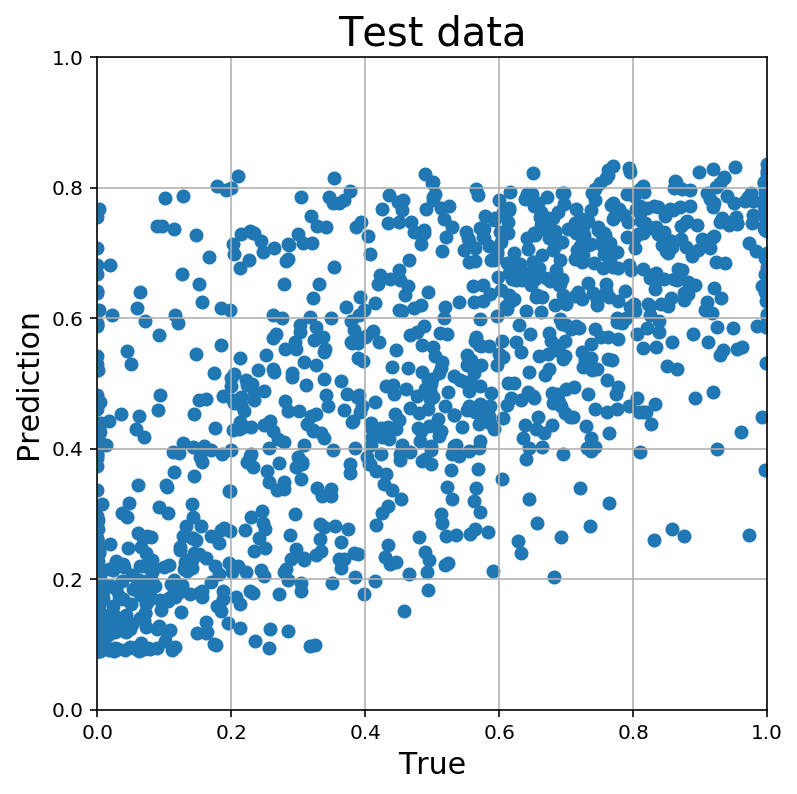

In [23]:
indel_predict = test_prediction
indel_true = test_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Test data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()

In [24]:
train_prediction = regression_model.predict(X_train).reshape(-1,)
train_true = rate_train.reshape(-1,)

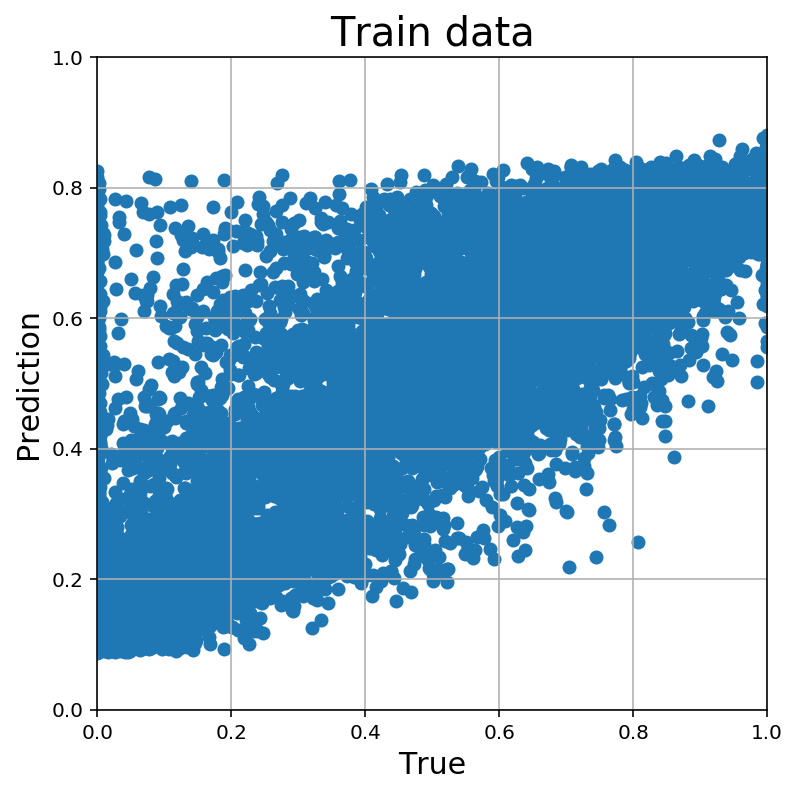

In [25]:
indel_predict = train_prediction
indel_true = train_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Train data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()